# Agent Architectures

An agent is considered **intelligent** if it **acts rationally**, meaning that for every possible sequence of perceptions, it chooses the action that maximizes the expected value of its performance measure, given its knowledge up to that moment. The environment, whether real (e.g., a physical space to navigate) or virtual (e.g., a software environment), can be partially observable, non-deterministic, dynamic, or even involve interactions with other agents. Agents can be physical (e.g., robots) or software-based. Regardless of form, an intelligent or rational agent makes the best possible decision given the available information. Artificial Intelligence focuses on designing such rational agents, ensuring they consistently make optimal choices. But how do we build an intelligent agent? Where do we begin? There is no single solution, but various approaches exist for developing agents of increasing complexity, all within a unifying paradigm:

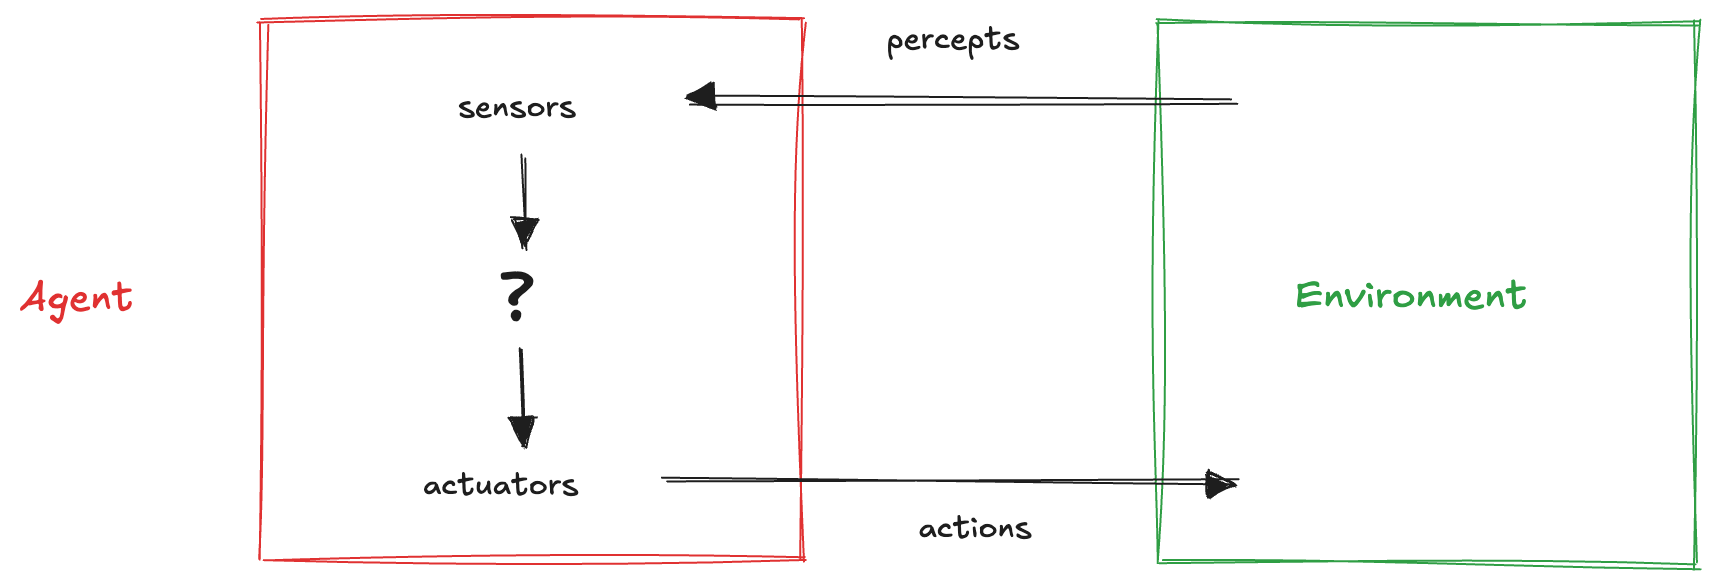

Each kind of agent program combines particular components in particular ways to generate actions. 

## Kinds of agent programs

We outline some basic kinds of agent programs that embody the principles underlying almost all intelligent systems:

- Simple reflex agents
- Model-based reflex agents
- Goal-based agents
- Utility-based agents

### Simple Reflex Agent

The simplest kind of agent is the simple reflex agent. These agents select actions **on the basis of the current percept, ignoring the rest of the percept history**:

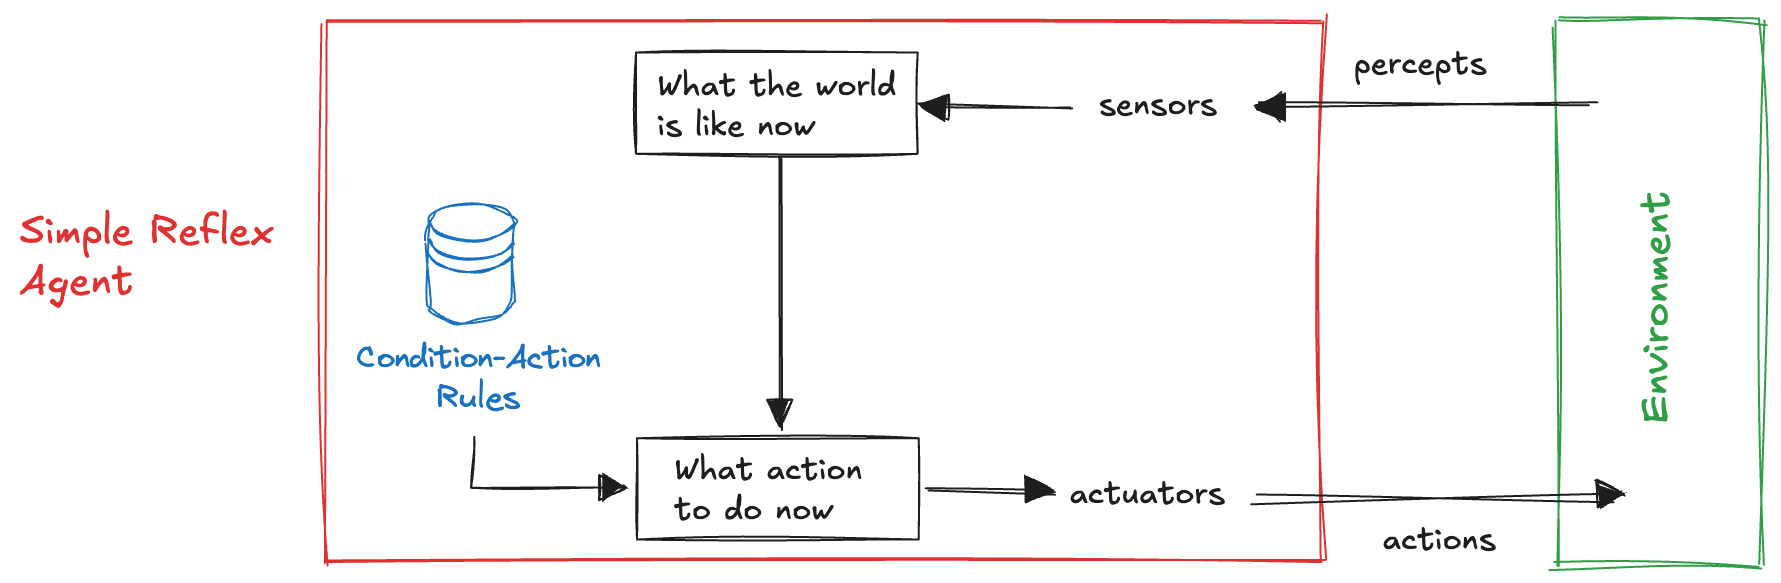

For example, the vacuum agent program suggested in the previous section (*If the current square is dirty, clean it; otherwise, move to the other square*) is a simple reflex agent, because its decision is based only on the current location and on whether that location contains dirt. We can implement this agent using the reflex agent program:

In [5]:
def SimpleReflexVacuumAgent():
    """
    This agent takes action based solely on the percept.
    """

    def program(percept):
        location, status = percept
        if status == 'Dirty':
            return 'Suck'
        elif location == "A":
            return 'Right'
        elif location == "B":
            return 'Left'

    return program

In [6]:
# Create the vacuum cleaner agent
agent = SimpleReflexVacuumAgent()

# Simulate inputs and outputs
print(agent(("A", "clean")))  
print(agent(("A", "dirty")))  
print(agent(("B", "clean")))  

Right
Right
Left


This program is much smaller than the lookup table because it **ignores percept history**, reducing complexity. Some actions, like cleaning a dirty square, are independent of location, further simplifying decision-making. **Reflex behaviors** apply even in complex environments. For example, an autonomous vehicle detects when the car ahead brakes by recognizing its brake lights and responds by initiating braking. Humans also rely on similar mechanisms, whether through learned responses or innate reflexes, such as blinking when something nears the eye. The previous program is specific to one particular environment. A more general and flexible approach is first to build a general-purpose interpreter for condition–action rules and then to create rule sets for specific environments:

In [7]:
def SimpleReflexAgent(rules, interpret_input):
    """
    This agent takes action based solely on the percept.
    """

    def program(percept):
        state = interpret_input(percept)
        rule = rule_match(state, rules)
        action = rule.action
        return action

    return program

The interpret_input() function abstracts the current state from sensory input, while rule_match() selects the first matching rule for that state. Reflex agents are **simple but limited in intelligence**, they will work only if the correct decision can be made on the basis of just the current percept. Partial observability can cause significant issues. For example, a braking rule based on a single video frame assumes the car ahead has a clearly identifiable brake light. However, older vehicles may have ambiguous taillight configurations, leading a reflex agent to either brake unnecessarily or fail to brake when needed. A similar problem arises in a vacuum agent with only a dirt sensor. Without location awareness, it may get stuck moving in the wrong direction (e.g. in in a "clean" A square he goes "left") indefinitely, resulting in an **infinite loop**. A possible solution is **randomization**. For instance, flipping a coin to decide whether to move "left" or "right" when encountering a clean square. On average, this allows the agent to reach and clean the other square in two steps. Hence, a **randomized reflex agent** might outperform a deterministic reflex agent. Randomized behavior can be rational, in some environments.

As an exmaple, the first versions of [**Roomba**](https://www.irobot.com/), the famous robotic vacuum cleaner, relied on a simple reflexive approach to navigation: it moved more or less randomly, using sensors to change direction whenever faced with an obstacle or the top of a set of steps. Another example is the [**IFTTT (If This Ten That)**](https://ifttt.com/) is a real-world example of tool to implement simple reflex agent. It follows a straightforward condition-action rule: when a specific event (percept) occurs, it triggers a predefined response (action). For example, an IFTTT applet could be set up as: if the weather forecast predicts rain then send a notification to carry an umbrella. It is a poweful tool to automate tasks based on a numerous possible triggers and actions.

#### Model-based reflex agents

An effective way to manage partial observability is for an agent to maintain an **internal state** that captures unobserved aspects of the environment based on its **percept history**. For instance, in braking scenarios, the agent only needs to store the previous camera frame to detect simultaneous activation of red brake lights. More complex tasks, like lane changes detection, require tracking other vehicles even when they are out of view. Updating this internal state requires two types of encoded knowledge:

1. **Transition model**: understanding how the world changes over time, including the effects of the actions (e.g., turning the steering wheel causes the car to turn) and independent changes (e.g., rain affecting camera visibility).
2. **Sensor model**: understanding how the state is reflected into sensor data (e.g., brake lights appearing as illuminated red regions in the camera feed).

By integrating these models, a **model-based reflex agent** can infer the current state of the world, to the extent possible given sensor limitations.

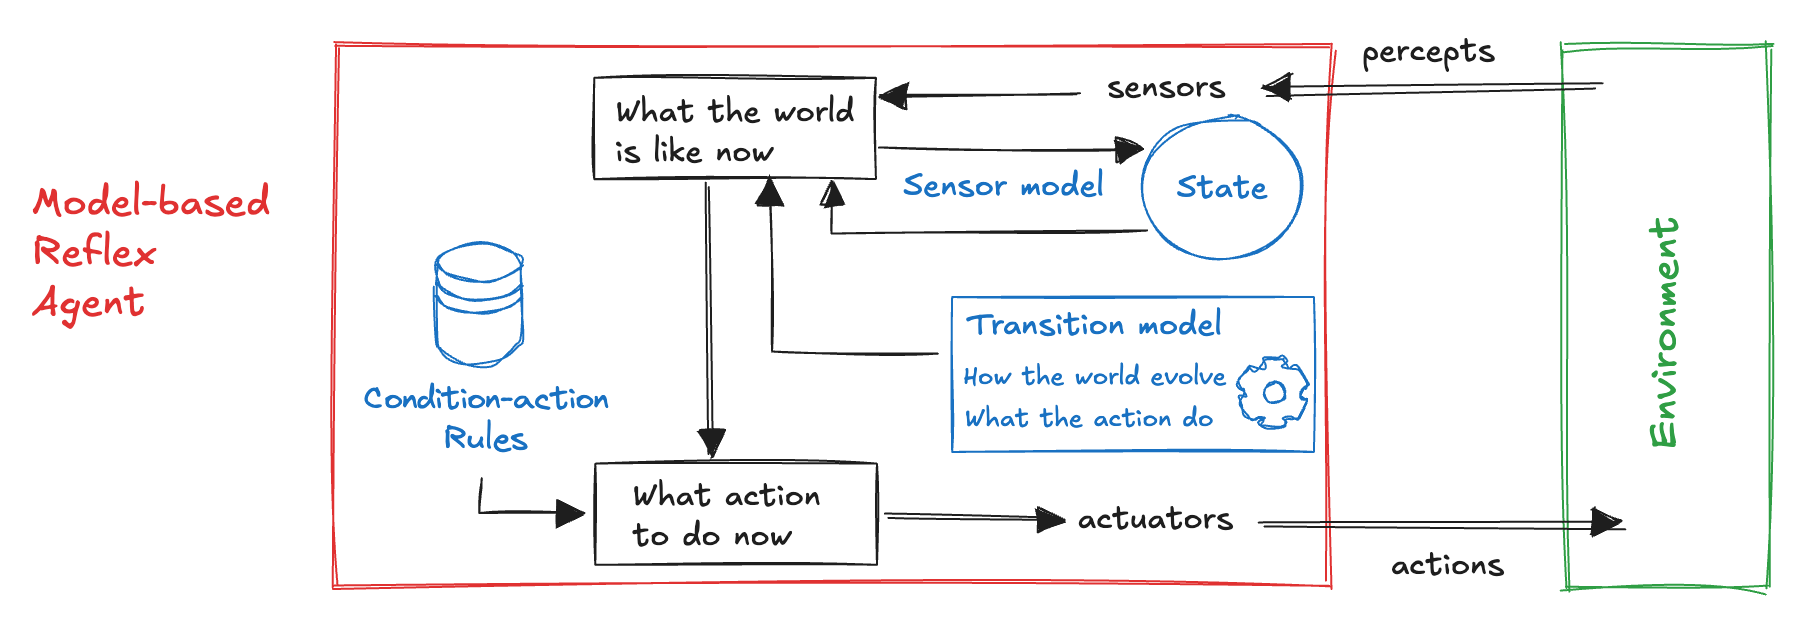

Notice that the agent updates its internal state by combining the current percept with previous state information, using a model of how the world operates. The representation of models and states varies depending on the environment and the agent design. However, in a partially observable environment, the exact state is rarely known with certainty. Despite this uncertainty, the agent must still make decisions based on the best available information.

The model-based approach for the vacuum cleaning problem can track the cleanliness of two locations and decides actions accordingly: it sucks when a location is dirty, moves between locations if needed, and stops when both are clean:

In [8]:
def ModelBasedReflexVacuumAgent():
    """An agent that keeps track of what locations are clean or dirty"""

    model = {"A": None, "B": None}

    def program(percept):
        location, status = percept

        # Update the model here
        model[location] = status 

        if model["A"] == model["B"] == 'Clean':
            return 'NoOp'
        elif status == 'Dirty':
            return 'Suck'
        elif location == "A":
            return 'Right'
        elif location == "B":
            return 'Left'

    return program

In [9]:
# Create the vacuum cleaner agent
agent = ModelBasedReflexVacuumAgent()

# Simulate inputs and outputs
print(agent(("A", "clean")))  
print(agent(("A", "dirty")))  
print(agent(("B", "clean")))  

Right
Right
Left


A generic implementation updates the state using a given model, matches the updated state to predefined rules, and selects an action accordingly:

In [10]:
def ModelBasedReflexAgentProgram(rules, update_state, model):
    """
    This agent takes action based on the percept and state
    """

    def program(percept):
        program.state = update_state(program.state, program.action, percept, model)
        rule = rule_match(program.state, rules)
        action = rule.action
        return action

    program.state = program.action = None
    return program

A real-world example of model-based agents in robotic vacuum cleaners includes the [**Roomba 980**](https://www.technologyreview.com/2015/09/16/247936/the-roomba-now-sees-and-maps-a-home/) and [**Dyson 360 Eye**](https://www.youtube.com/watch?v=oguKCHP7jNQ&t). Unlike earlier models that relied on random movement, these robots use an algorithm to build a map of their environment while navigating. The Roomba 980 creates a visual map to track its position, ensuring complete coverage and avoiding redundant cleaning, while the Dyson uses a 360-degree camera to continuously scan its surroundings, constructing a detailed map to navigate efficiently and avoid obstacles. By leveraging the map, these vacuums intelligently adapt their cleaning patterns for optimal performance.

### Goal-based agents

Knowing something about the current state of the environment is not always enough to decide what to do. For example, at a road junction, the vehicle can turn left, turn right, or go straight on. The correct decision depends on where the vehicle is trying to get to. In other words, as well as a current state description, the agent needs some sort of **goal information** that describes situations that are desirable (for example, being at a particular destination). 

The agent program can combine this with the model to choose actions that achieve the goal. 

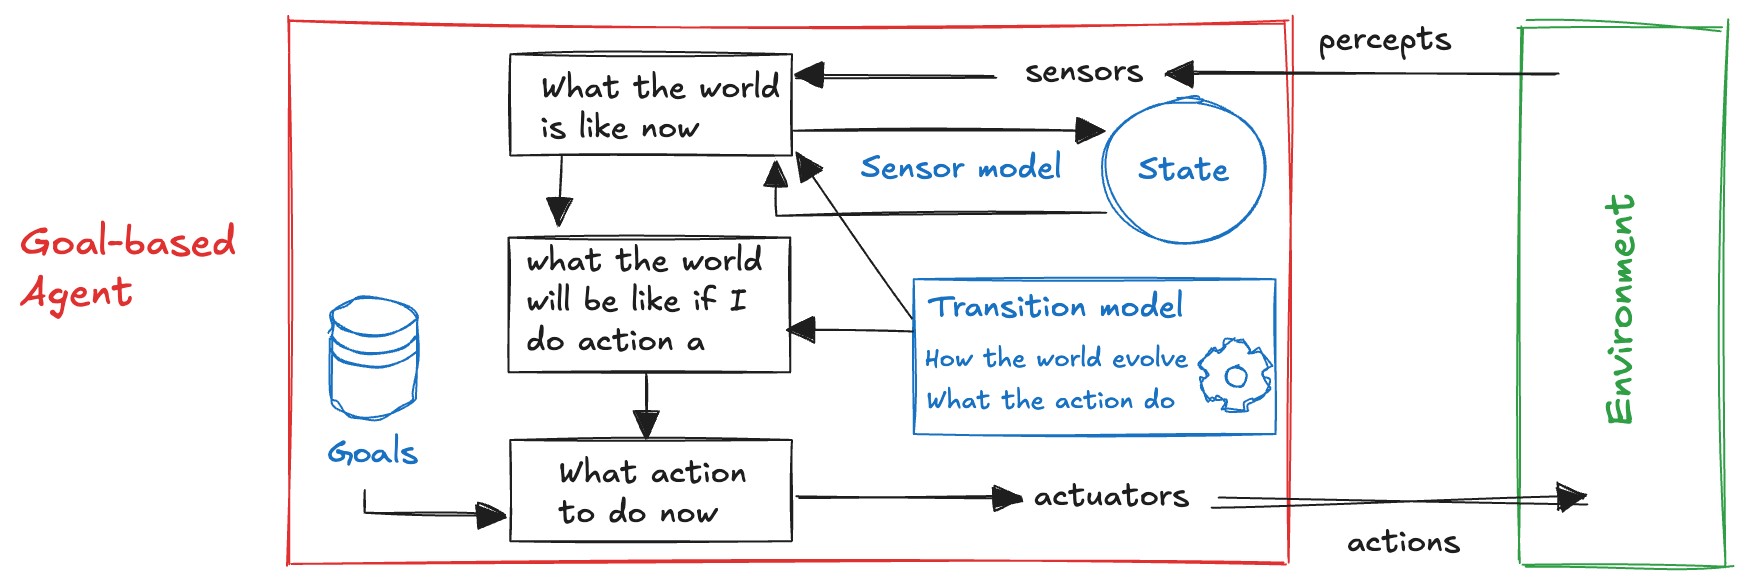

Goal-based action selection can be simple when a single action achieves the goal, but more complex when the agent must plan a sequence of actions. For example, when the agent has to consider long sequences of twists and turns in order to find a way to achieve the goal. **Search** and **planning** in AI focus on finding such action sequences. Unlike reflex agents, that react to percepts with fixed rules, goal-based agents **consider future outcomes** to determine the best action. For example, a reflex agent brakes upon seeing brake lights without understanding why, while a goal-based agent does so to avoid a collision. This approach is more **flexible** since **goals can be modified** without rewriting decision rules, allowing the agent to **adapt** to new tasks. For example, a goal-based agent behavior can easily be changed to go to a different destination simply by specifying that destination as the goal. The reflex agent’s rules for when to turn and when to go straight will work only for a single destination; they must all be replaced to go somewhere new.

As an example, the game of **Tic-tac-toe**, like all deterministic board games, can be solved using a goal-based agent that evaluates possible move sequences to achieve victory. By employing search algorithms like **minimax**, the agent systematically explores future game states to determine the optimal move:

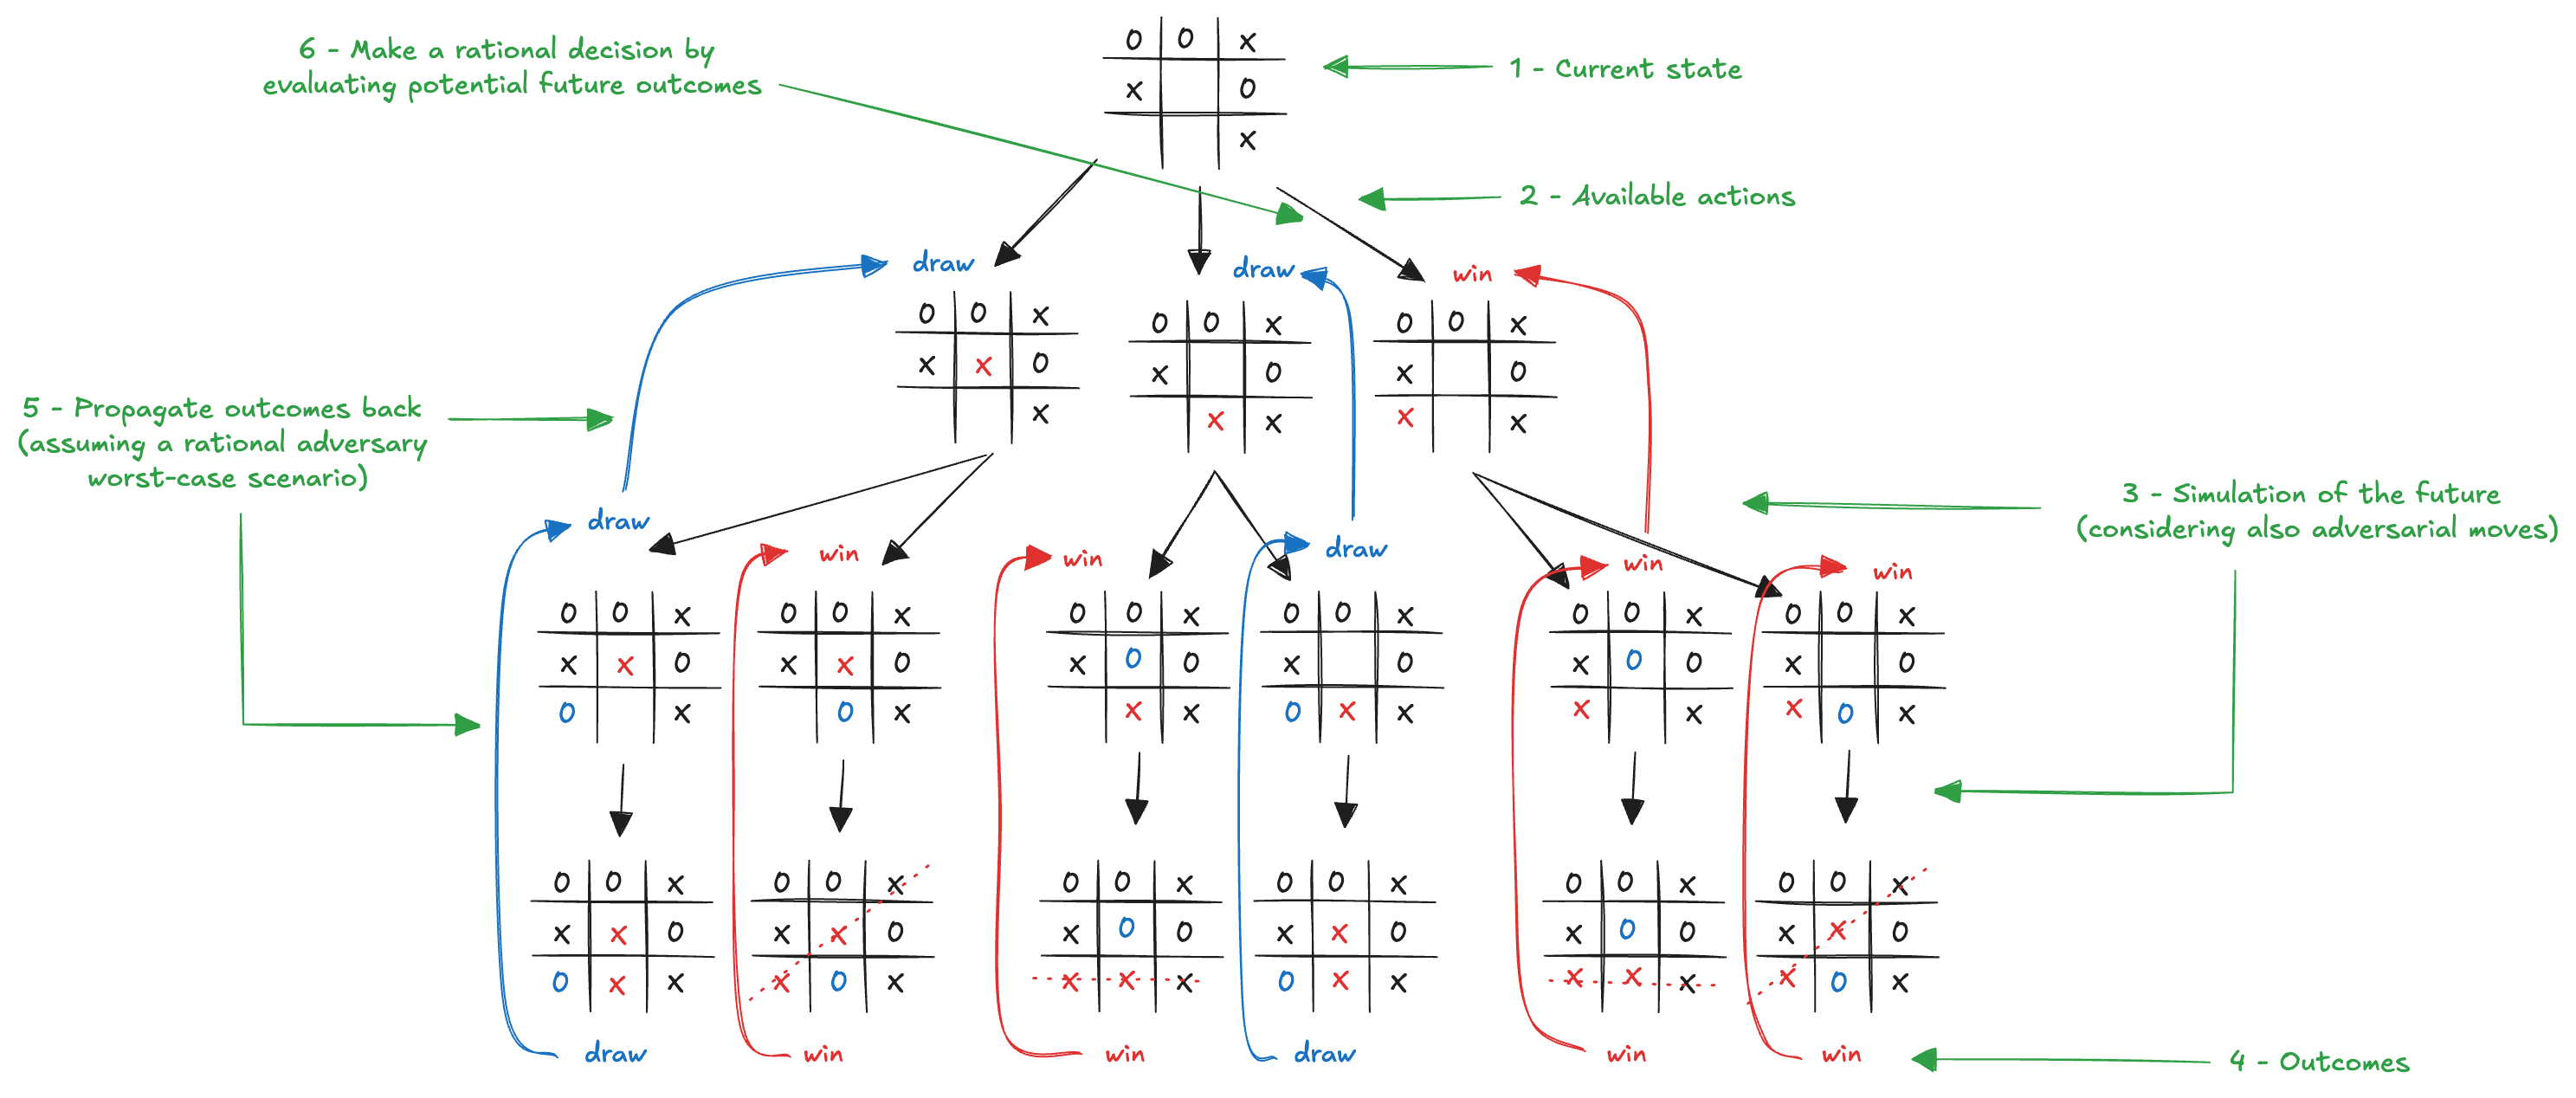

### Utility-based agents

Goals alone are insufficient for generating high-quality behavior in most environments. While many action sequences can achieve a goal, some are faster, safer, or more efficient. Goals offer only a binary distinction between success and failure, whereas a **performance measure** allows comparisons based on **how desirable** different outcomes are. Economists and computer scientists use the term **utility** to quantify this preference. We have already seen that a performance measure assigns a score to any given sequence of states, so it can be used to distinguish between more and less desirable ways of getting the goal. An **utility function** is an **internalization** of the performance measure. Provided that the internal utility function and the external performance measure are in agreement, an agent that chooses actions to maximize its utility will be rational according to the external performance measure. 

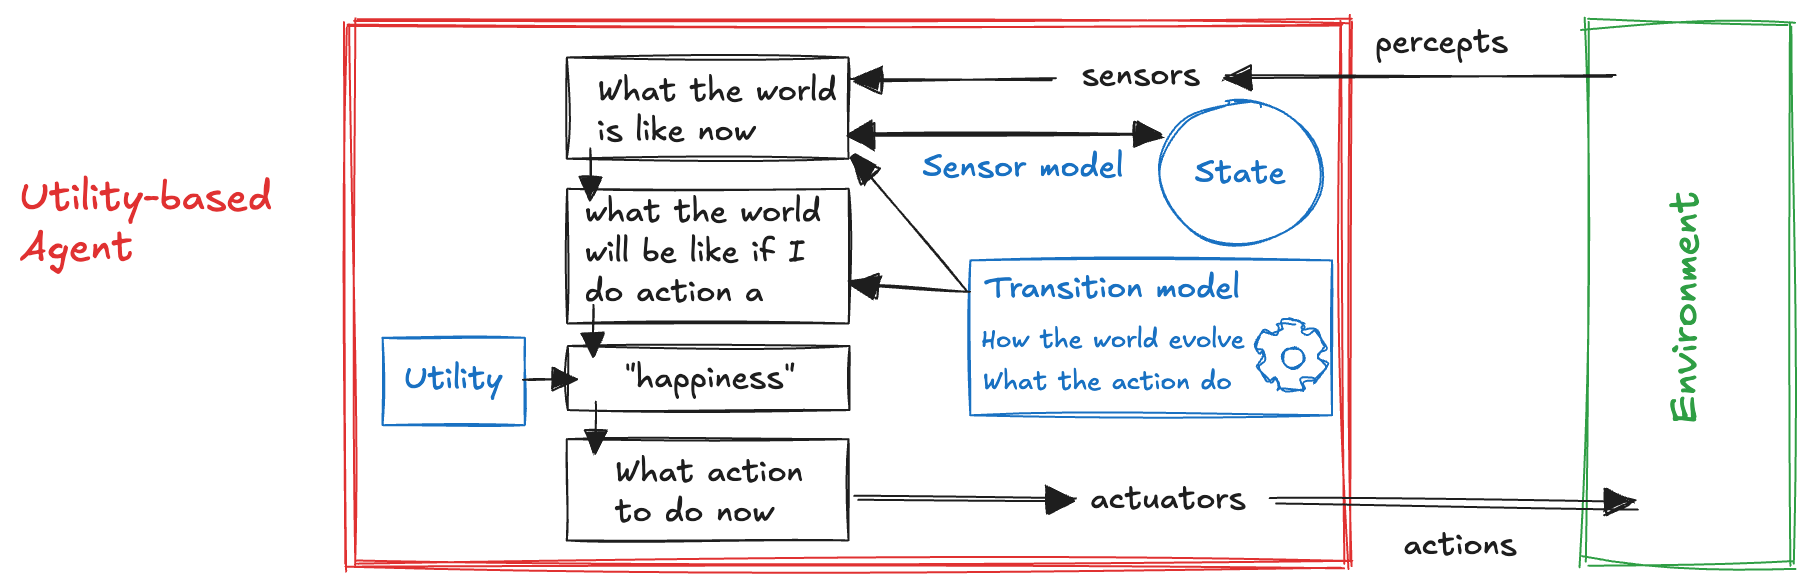

Partial observability and non-determinism are inherent in the real world, making **decision-making under uncertainty** essential. A rational **utility-based agent** selects actions that **maximize expected utility** of the action outcomes, that is, the utility the agent expects to derive, **on average**, given the probabilities and utilities of each outcome. This is challenging, requiring research in **perception**, **representation**, **reasoning**, and **learning**. The agent must track its environment, and **selecting optimal actions** demands **efficient algorithm**s. **Perfect rationality** is often **impractical** due to computational limits. While many utility-based agents are model-based, **model-free agents** can learn optimal actions without understanding their environmental impact.

### Component Representation  

Agent programs consist of various components, which can be represented with increasing levels of complexity and expressiveness:

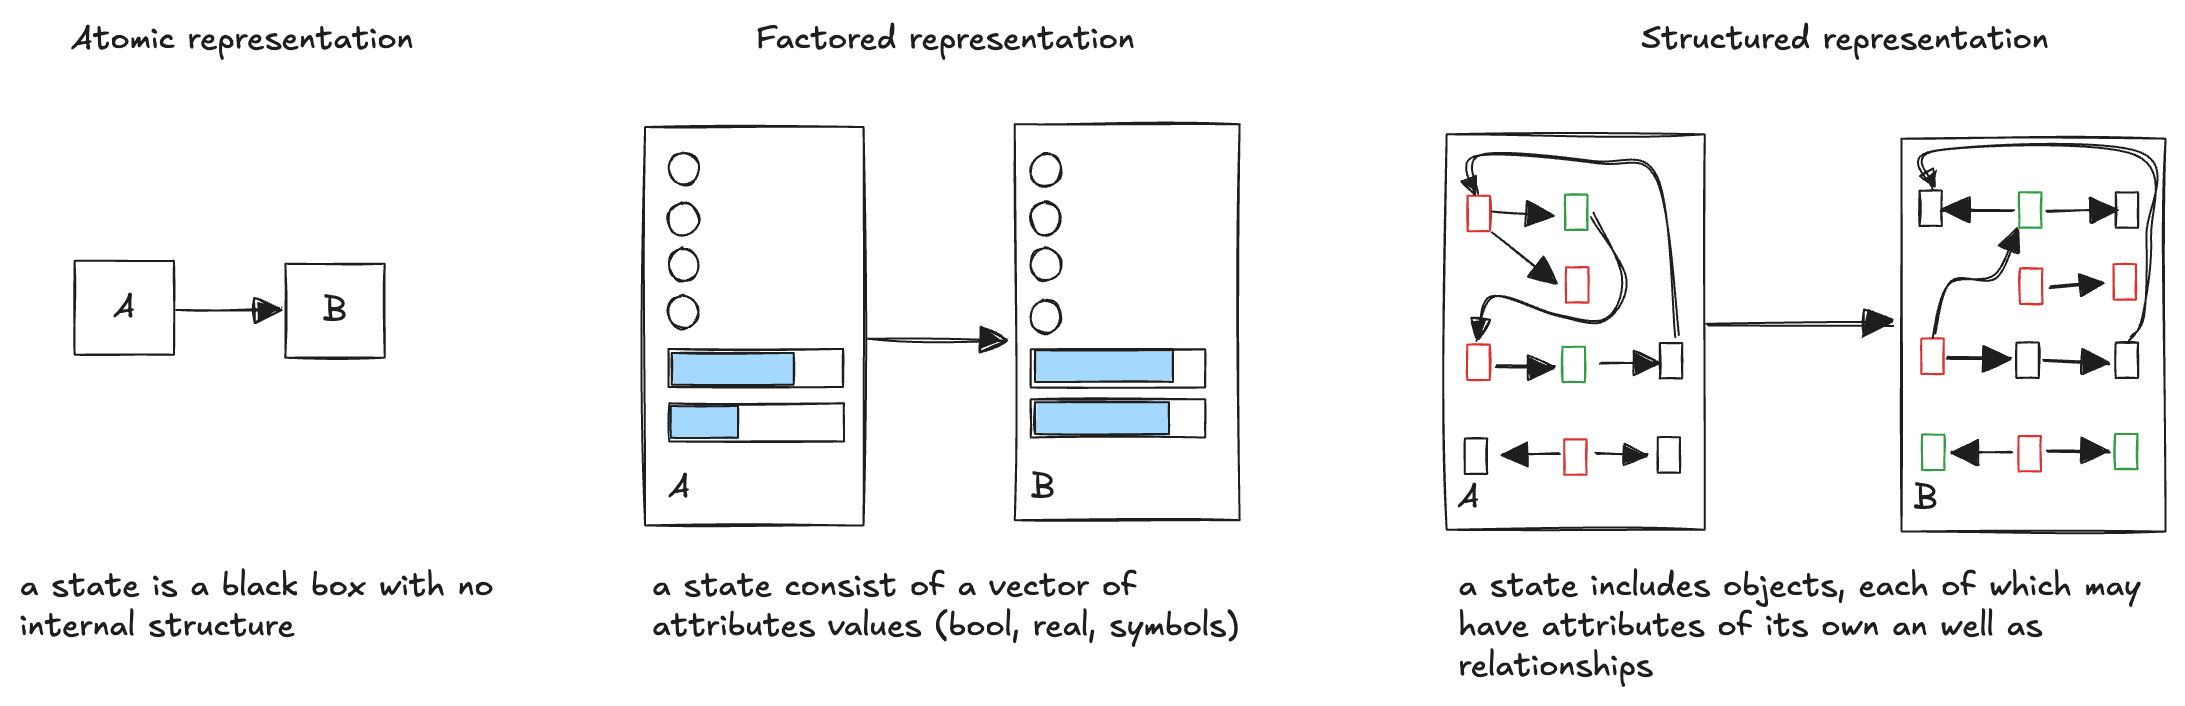

In an **atomic representation**, a state of the world is indivisible, lacking internal structure. For example, when planning a driving route, the state could be reduced to the name of the current city, just a "black box" distinguishable only from others. 
A **factored representation** breaks a state into a set of variables or attributes, each with a value. In the driving example, this could include fuel level, GPS coordinates, and vehicle status. Unlike atomic representations, factored states share common attributes, making it easier to transition from one state to another.

A **structured representation** captures relationships between objects. Instead of just variables, it describes entities like trucks, cows, and their interactions, for example, a truck backing into a driveway being blocked by a cow. 

These representations form a spectrum of increasing **expressiveness**. More expressive representations can describe everything a simpler one can often more concisely, but at the cost of increased complexity in reasoning and learning. For instance, chess rules require just a few pages in structured representations, but thousands in factored representations and an astronomical number in atomic representations. To **balance expressiveness and efficiency**, intelligent systems often operate across multiple levels of representation.

## Learning

We have explored various agent architectures but not **how they are created**. Turing (1950) suggested programming intelligent machines **by hand**, but recognized its **impracticality**, advocating instead for **learning machines** that improve through experience. Today, this approach dominates AI, enabling any agent type (model-based, goal-based, or utility-based) to learn and adapt. Learning allows the agent to operate in initially unknown environments and to become more competent than its initial knowledge alone might allow. A learning agent consists of four key components:

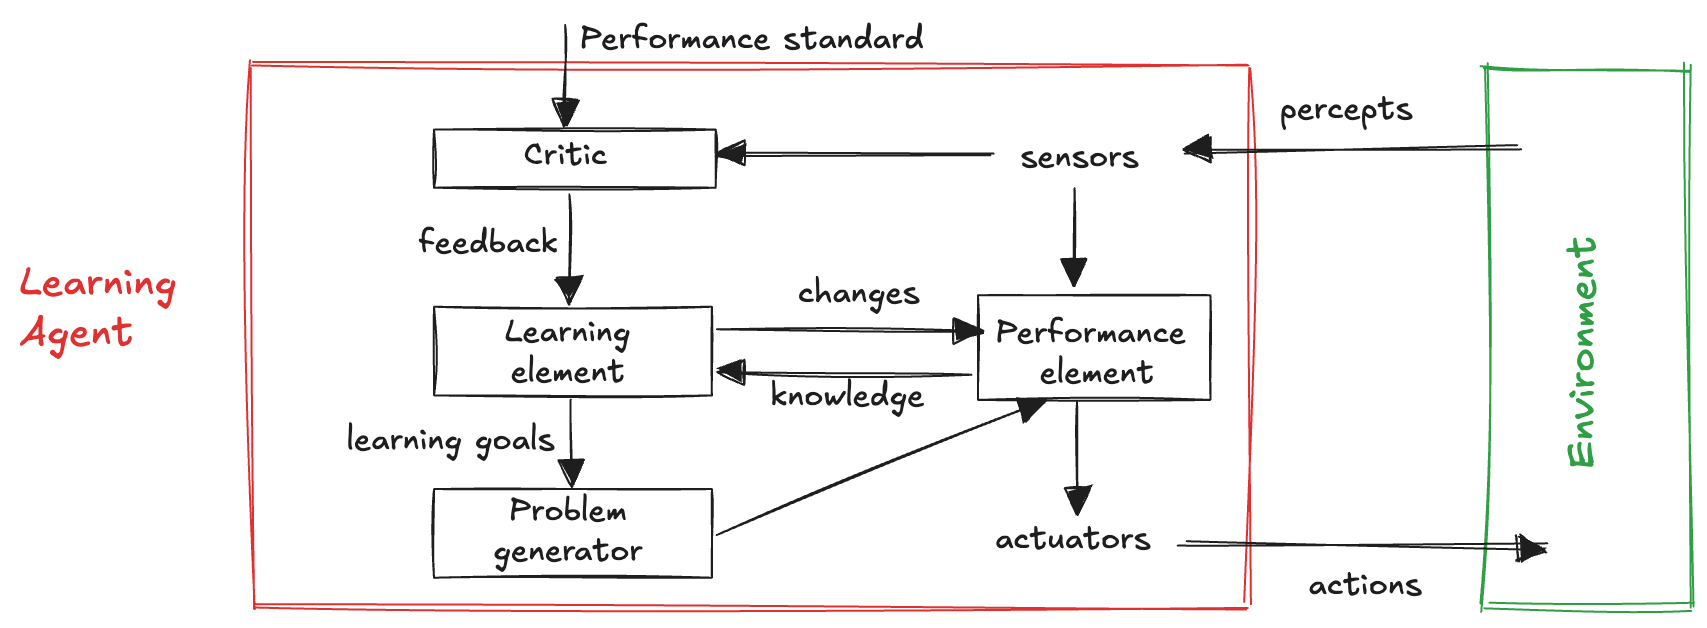

The **learning element** is responsible for **improving** the agent behavior, while the **performance element** (what we have previously considered to be the entire agent) selects actions based on percepts.  Learning means modifying internal components (how the world works, the effects of their actions, their goals, etc.). It is possible to **learn directly from observing the environment**, like an automated vehicle learning the effects of braking on different road surfaces. The **problem generator** can even **experiments**. This means try actions different from the actions that the performance element sleects in order to lead to new and informative experiences and uncover better long-term strategies. The learning element uses feedback (**reward or penalty signal**) from a **critic**, respect to a **fixed performance standard**, on how the agent is doing and determines how the performance element **should be modified** to do better in the future. The critic is essential because percepts alone do not indicate success; for example, a chess program may detect a checkmate but needs a performance standard to recognize it as a positive outcome.  Whether hard-wired (like pain in humans) or learned from human behavior (like preferences provided by the user), this feedback drives the learning process.  Ultimately, learning in intelligent agents is about refining each component to better align with available feedback, thus improving overall performance.

## An example: Flocking

The paper ["Flocks, Herds, and Schools: A Distributed Behavioral Model"](./papers/(1987)%20-%20Flocks,%20Herds,%20and%20Schools%20-%20A%20Distributed%20Behavioral%20Model.pdf) by C. W. Reynolds, published in SIGGRAPH 1987, presents a model simulating the collective behavior of animals like birds, fish, and ants. Reynolds introduces a model of such collective behavior (refered to as **flocking**), where each entity (a **boid**) follows simple local rules based on its environment, resulting in complex group motion. The model consists of three main rules:

- **Separation rule** avoids crowding neighbors to prevent agents from colliding
- **Cohesion rule** steers the agent towards the average position of neighbors, to keep agents together
- **Alignment rule** steers the agent towards the average heading of neighbors, to ensure agents move in the same direction

Each rule provides a **simple heuristic** for the agent to follow, based on the positions and velocities of nearby agents. The agent has a **limited perception range**, only considering neighbors within a certain radius.The rules determine how each entity moves at every instant by generating **competing acceleration requests** (forces):

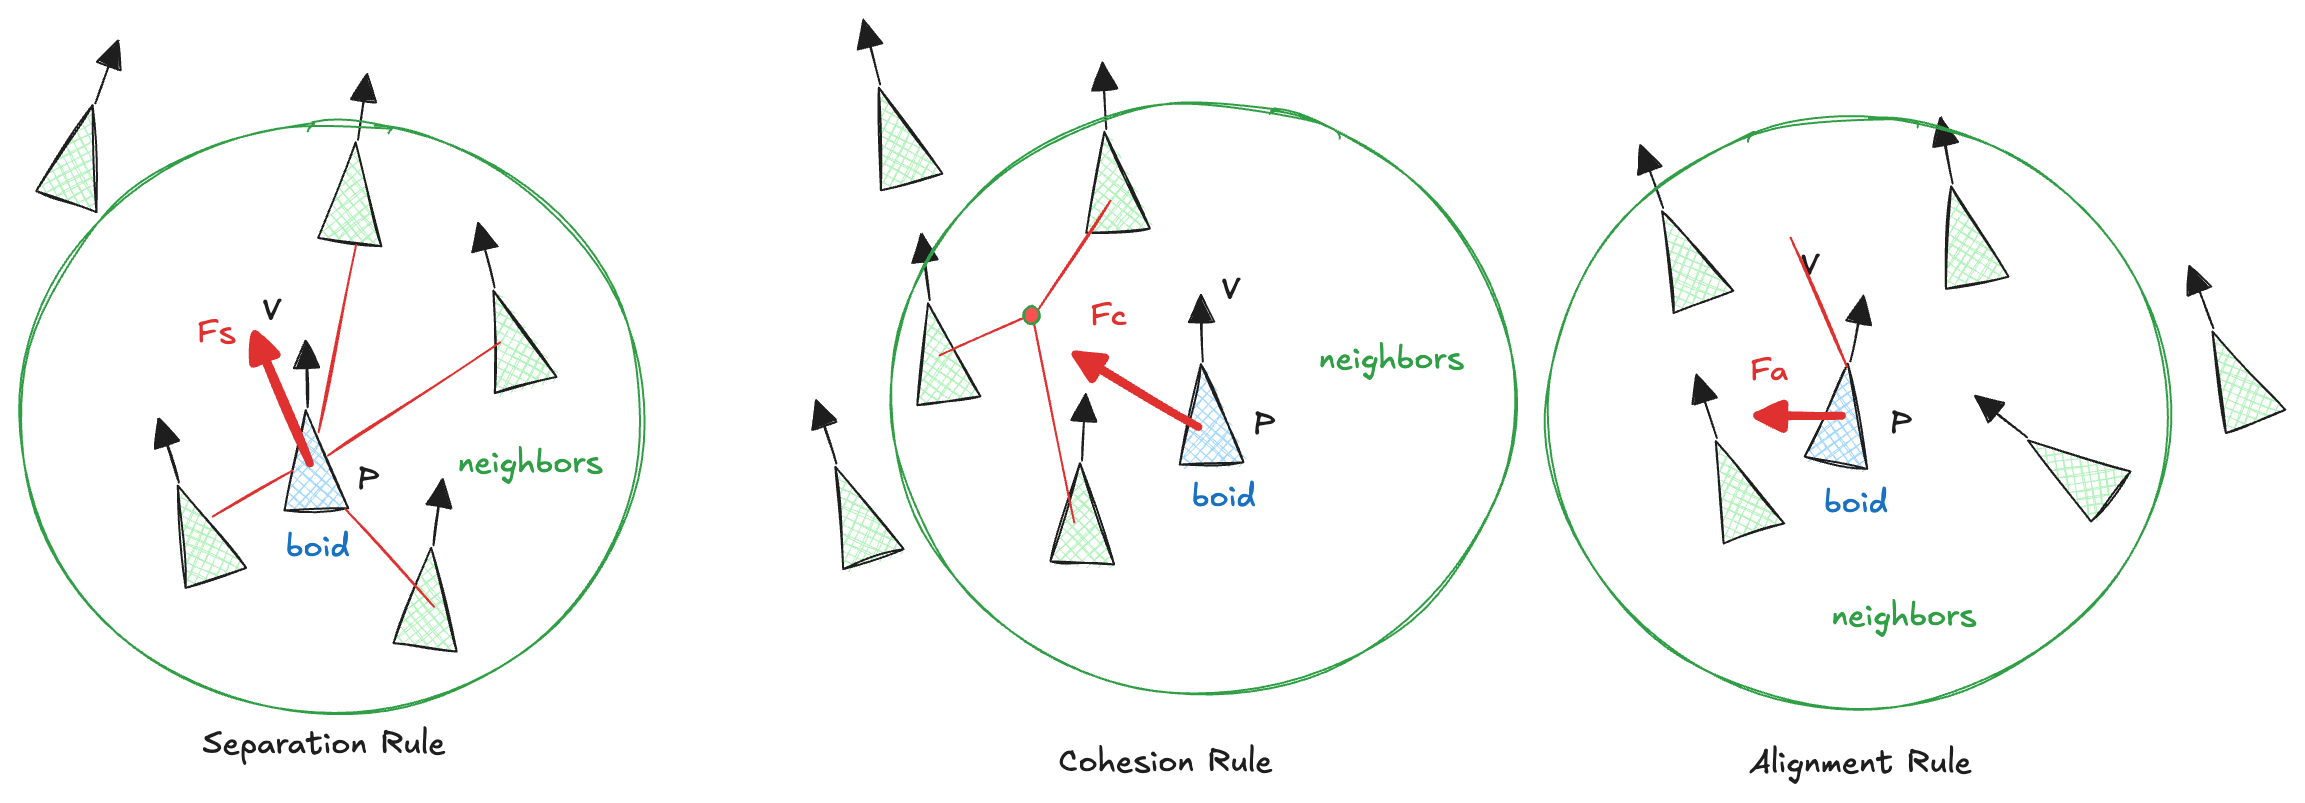

These forces are combined to compute the final force applied to an agent at each moment and to update its position and velocity exploiting a simplen **Euler integration rule**. Given a boid with position p(t), velocity v(t), and acceleration a(t), the Euler update is given by:

$\displaystyle \mathbf{v}(t + \Delta t) = \mathbf{v}(t) + \mathbf{a}(t) \Delta t$

$\displaystyle \mathbf{p}(t + \Delta t) = \mathbf{p}(t) + \mathbf{v}(t) \Delta t$

The acceleration a(t) is determined by the sum of various forces acting on the "boid"):

$\displaystyle \mathbf{a}(t) = \frac{\mathbf{F}(t)}{m}$

where F(t) is the total force acting on the boid as a weighted sum of different flocking forces (alignment, cohesion, separation) and eventually other external force:

$\displaystyle \mathbf{F}(t) = w_{\text{align}} \mathbf{F}_{\text{align}} + w_{\text{cohesion}} \mathbf{F}_{\text{cohesion}} + w_{\text{separation}} \mathbf{F}_{\text{separation}} + \mathbf{F}_{\text{external}}$

This iterative update is applied at each simulation step, making the boids move dynamically according to the flocking rules. Different rules can be weighted to achieve different behaviors. The model is **decentralized**, meaning that each agent makes decisions based only on its local environment, without any global knowledge. 

We consider a simplified 2D implementation using the three main rules and a model-based agent architecture to implement the single boid. The agent maintains an internal state with its position and velocity, and updates them based on the flocking rules:

In [11]:
import numpy as np

def separation(boid, neighbors):
    # Initialize the force vector
    force = np.zeros(2)

    # If there are no neighbors, return the zero vector
    if not neighbors: 
        return force

    # Loop over all neighbors  
    for neighbor in neighbors:

        # Calculate the distance between the agent and its neighbor
        distance = np.linalg.norm(boid['position'] - neighbor['position'])

        # Calculate the direction to steer away from the neighbor (normalized)
        direction_to_neighbor = neighbor['position'] - boid['position']
        direction_to_neighbor = direction_to_neighbor / (np.linalg.norm(direction_to_neighbor) + 0.01)

        # Calculate a weight based on distance.
        # Closer neighbors get a higher weight (stronger influence).
        weight = 1 / (distance + 0.01)  
        
        # Add the contribution of this neighbor to the total force
        force -= direction_to_neighbor * weight

    # Normalize the force vector (it is optional, but makes 
    # things easier to tune)
    force = force / np.linalg.norm(force)
    
    return force

In [12]:
def cohesion(boid, neighbors):
    # Initialize the force vector
    force = np.zeros(2)

    # If there are no neighbors, return the zero vector
    if not neighbors: 
        return force
    
    # Initialize the center of mass of neighbors
    center_of_mass = np.zeros(2)

    # Loop over all neighbors
    for neighbor in neighbors:
        # update the center of mass
        center_of_mass += neighbor['position'] 
    center_of_mass /= len(neighbors)

    # Calculate the force contribution as the distance to the center of mass
    force = center_of_mass - boid['position']

    # Normalize the force vector (it is optional, but makes 
    # things easier to tune)
    force = force / np.linalg.norm(force)
    
    return force

In [13]:
def alignment(boid, neighbors):

    # Initialize the force vector
    force = np.zeros(2)

    # If there are no neighbors, return the zero vector
    if not neighbors: 
        return force

    # Initialize the average velocity of neighbors
    avg_velocity = np.zeros(2)

    # Loop over all neighbors
    for neighbor in neighbors:
        # Update the average velocity
        avg_velocity += neighbor['velocity']
    avg_velocity /= len(neighbors)

    # Calculate the force contribution as the difference between 
    # the agent's velocity and the average velocity of its neighbors
    force = avg_velocity - boid['velocity']

    # Normalize the force vector (it is optional, but makes 
    # things easier to tune)
    force = force / np.linalg.norm(force)

    return force

In order to generate some overall flocking behavior, we can add a force contribution that steers the boid towards a target position. This can be made more complex by adding obstacles, predators, or other agents with different behaviors.

In [14]:
def direction(boid, target):

    # Initialize the force vector
    force = np.zeros(2)

    # Calculate the force contribution as the difference between 
    # the agent's posistion and the target position
    force = target - boid['position']
    
    # Normalize the force vector (it is optional, but makes 
    # things easier to tune)
    force = force / np.linalg.norm(force)

    return force

Now we write the Euler integration funtion to update the state of a boid based on the percept, in that case the positions and velocities of the other boids:

In [15]:
def update_state(boid, percept, model):
    neighbors = percept['neighbors']

    # Calculate the forces (weights are applied here)
    separation_force = model['separation_force_factor'] * separation(boid, neighbors)
    alignment_force = model['alignment_force_factor']  * alignment(boid, neighbors)
    cohesion_force = model['cohesion_force_factor']  * cohesion(boid, neighbors)
    target_force = model['target_force_factor']  * direction(boid, model['target'])

    # Random Force. This is an external force to add some randomness 
    # to the movement, due to the fact that the boids are not perfect
    random_force = model['random_force_factor'] * (2 * np.random.rand(2) - 1);
    
    # Combine the forces
    force = separation_force + cohesion_force + alignment_force + random_force + target_force

    # Update the velocity (considering mass = 1 and delta_t = 1 for simplicity) 
    boid['velocity'] += force
    
    # Speed Limiting (optional but often helpful)
    speed = np.linalg.norm(boid['velocity'])
    if speed > model['max_speed']:
        boid['velocity'] = (boid['velocity']/speed) * model['max_speed']

    # Update the position
    boid['position'] += boid['velocity']
    
    return boid


Now we can implement the model-based agent. In this simple case we just update the state without selecting any action based on the state. The behaviour can be made more complex by adding a goal or utility function to the agent.

In [16]:
def ModelBasedAgent(update_state, model):
    
    def program(percept):
        program.state = update_state(program.state, percept, model)
    
    program.state = {'position': 10 * np.random.rand(2), 'velocity': (np.random.rand(2) - 0.5)}
    return program

The perception of a boid is limited to a certain radius, so we need to filter the boids that are within this radius. This is the sensor function of our agent:

In [43]:
def sensors(boid, boids, radius):
    neighbors = []
    for other_boid in boids:
        if other_boid is not boid:  # Avoid self-comparison
            distance = np.linalg.norm(other_boid['position'] - boid['position'])
            if distance < radius:
                neighbors.append(other_boid)
    return neighbors

We need a function to simulate the environment, including time step updates and position visualization. Using Matplotlib and its animation module, we can generate a dynamic scatter plot to display boid positions at each time step:

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def simulation(boids, model, num_frames):
    # Set up the figure and axis
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, 100), ylim=(-10, 100))

    # Initialize positions for visualization
    positions = [boid.state['position'] for boid in boids]

    # Create a scatter plot
    scat = ax.scatter([pos[0] for pos in positions], [pos[1] for pos in positions])
    
    # Update the scatter plot each frame
    def update(frame):    
        # Loop over all boids
        for boid in boids:
            
            # Get the neighbors
            # neighbors = sensors(boid, boids, model)
            neighbors = sensors(boid.state, [b.state for b in boids], model['perception_radius'])

            # Prepare the percept
            percept = {'neighbors': neighbors}
            
            # Update the state of the boid
            boid(percept)
    
        # Update positions for visualization
        positions = [boid.state['position'] for boid in boids]
    
        # Update scatter plot data
        scat.set_offsets(positions)
    
        return scat,

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

    plt.close()

    return anim

Now we can experiment with different model parameters and weights to observe the emergent flocking behavior. For example, we can adjust the weights of the alignment, cohesion, and separation rules to observe how they affect the flocking dynamics. We can also introduce additional forces or rules to create more complex behaviors. The model-based agent architecture allows for easy modification and extension of the agent's behavior, making it a flexible framework for simulating intelligent agents.

In [47]:
# Define the model parameters
model = {'separation_force_factor': 1.2,
         'alignment_force_factor': 1,
         'cohesion_force_factor': 0.2,
         'random_force_factor': 1,
         'target_force_factor': 1,
         'perception_radius': 10,
         'max_speed': 2.0,
         'target': np.array([80, 80])} 

# Define the number of agents
num_agents = 30

# Definte the number of frames
num_frames = 200

# Create a first set of boids
boids = [ModelBasedAgent(update_state, model) for _ in range(num_agents)]

# Run the simulation
anim = simulation(boids, model, num_frames)

anim

The model has been widely used in computer graphics, animation, and robotics to simulate realistic group motion.